In [1]:
!git clone --recursive https://github.com/WongKinYiu/yolov9.git
%cd yolov9/

Cloning into 'yolov9'...
remote: Enumerating objects: 781, done.
remote: Total 781 (delta 0), reused 0 (delta 0), pack-reused 781 (from 1)
Receiving objects: 100% (781/781), 3.27 MiB | 18.50 MiB/s, done.
Resolving deltas: 100% (330/330), done.
/kaggle/working/yolov9


In [2]:
!pip install -r requirements.txt -q
!pip install supervision datasets pyyaml -q

In [3]:
from PIL import Image
import warnings
import torch
import cv2
import glob
import os
import random

import pandas as pd
import numpy as np
import supervision as sv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

warnings.simplefilter('ignore')

In [4]:
HOME = os.getcwd()
HOME

'/kaggle/working/yolov9'

In [5]:
from datasets import load_dataset, DatasetDict

In [6]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [7]:
image_dir = "/kaggle/input/pedestriandataset/images"
label_dir = "/kaggle/input/pedestriandataset/etiquetas"

image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

data = []

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    
    label_file = image_file.replace(".jpg", ".txt")
    label_path = os.path.join(label_dir, label_file)
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            label = f.readline().strip()  
        
        data.append([image_path, label])
    else:
        print(f"Label file missing for {image_file}, skipping.")

combined_df = pd.DataFrame(data, columns=["image_path", "label"])
combined_csv_path = "/kaggle/working/combined_dataset.csv"
combined_df.to_csv(combined_csv_path, index=False)

print(f"Combined dataset saved to {combined_csv_path}")

Combined dataset saved to /kaggle/working/combined_dataset.csv


In [8]:
# First, attempt stratified split, and handle rare classes if it fails
try:
    # Initial stratified split with 70% train and 30% temp
    train_df, temp_df = train_test_split(combined_df, test_size=0.3, random_state=42, stratify=combined_df['label'])

    # Further split temp set into val (15%) and test (15%) using stratification
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

except ValueError as e:
    print(f"Stratification failed due to rare classes: {e}. Proceeding without stratification.")

    # Non-stratified split if stratified fails
    train_df, temp_df = train_test_split(combined_df, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Save each split to separate CSV files
train_csv_path = "/kaggle/working/train_dataset.csv"
val_csv_path = "/kaggle/working/val_dataset.csv"
test_csv_path = "/kaggle/working/test_dataset.csv"

train_df.to_csv(train_csv_path, index=False)
val_df.to_csv(val_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print(f"Train dataset saved to {train_csv_path}")
print(f"Validation dataset saved to {val_csv_path}")
print(f"Test dataset saved to {test_csv_path}")


Stratification failed due to rare classes: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.. Proceeding without stratification.
Train dataset saved to /kaggle/working/train_dataset.csv
Validation dataset saved to /kaggle/working/val_dataset.csv
Test dataset saved to /kaggle/working/test_dataset.csv


In [9]:
# Assuming you have split datasets in train_df, val_df, and test_df as shown before

# Display the number of images in each split
print(f"Number of images in the training set: {train_df.shape[0]}")
print(f"Number of images in the validation set: {val_df.shape[0]}")
print(f"Number of images in the test set: {test_df.shape[0]}")

Number of images in the training set: 4426
Number of images in the validation set: 949
Number of images in the test set: 949


In [10]:
def show_random_class(dataset, random_index: int = 0, from_where: str = 'test'):
    
    _, ax = plt.subplots(1)

    random_range = len(dataset[from_where])

    assert random_index < random_range, f'Dataset includes {random_range} samples. random_index must be <= {random_range - 1}.'

    random_sample = dataset[from_where][random_index]
    img = random_sample['image']
    label = random_sample['label']  

    ax.imshow(img)
    ax.axis('off')

    ax.set_title(f'Class: {label}', fontsize=15, color='blue')

    plt.show()

In [11]:
from PIL import Image

# Prepare dataset in the required format without image_id
dataset = {
    'train': [
        {
            'image': Image.open(row['image_path']),
            'label': row['label'],
            'file_name': os.path.basename(row['image_path'])  # Use the file name directly
        }
        for _, row in train_df.iterrows()
    ],
    'validation': [
        {
            'image': Image.open(row['image_path']),
            'label': row['label'],
            'file_name': os.path.basename(row['image_path'])  # Use the file name directly
        }
        for _, row in val_df.iterrows()
    ],
    'test': [
        {
            'image': Image.open(row['image_path']),
            'label': row['label'],
            'file_name': os.path.basename(row['image_path'])  # Use the file name directly
        }
        for _, row in test_df.iterrows()
    ]
}

In [12]:
def datasets_transform(dataset, base_dir: str) -> None:
    # Define splits for the dataset
    splits = ['train', 'validation', 'test']

    for split in splits:
        # Create directories for images and labels if they don't exist
        split_image_dir = f'{base_dir}/data/{split}/images/'
        split_label_dir = f'{base_dir}/data/{split}/labels/'
        
        os.makedirs(split_image_dir, exist_ok=True)
        os.makedirs(split_label_dir, exist_ok=True)

        # Loop over each row in the split dataset
        for row in dataset[split]:
            # Save image to the images directory using file_name
            row['image'].save(fp=f"{split_image_dir}{row['file_name']}")

            # Save label to a text file in the labels directory
            label = row['label']
            label_file_path = f"{split_label_dir}{row['file_name'].replace('.jpg', '.txt')}"
            with open(label_file_path, 'w') as f:
                f.write(str(label))  # Write the label as a single line


In [13]:
datasets_transform(dataset=dataset, base_dir=HOME)

print('\033[92mSUCCESSFULLY TRANSFORMED INTO DESIRED YOLOv9 FORMAT!\033[0m')

SUCCESSFULLY TRANSFORMED INTO DESIRED YOLOv9 FORMAT!


In [14]:
def create_yaml(base_dir: str, num_classes: int, class_names: list):
    import yaml

    # Ensure class_names is a dictionary with indices matching the class labels
    data_yaml = {
        'train': 'data/train/images',
        'val': 'data/validation/images',
        'test': 'data/test/images',
        'nc': num_classes,  # number of classes
        'names': {i: name for i, name in enumerate(class_names)}  # dynamically generate names
    }

    with open(f'{base_dir}/custom_data.yaml', 'w') as file:
        yaml.dump(data_yaml, file)

# Example usage
num_classes = 4  # Replace this with the actual number of classes in your dataset
class_names = ['MMNAP', 'MMAP', 'MNAP', 'PCP']  # Replace with your actual class names
create_yaml(base_dir=HOME, num_classes=num_classes, class_names=class_names)


In [15]:
MODELS: dict = {
    'GELAN-C': {
        'yaml': 'models/detect/gelan-c.yaml',
        'weights': f'{HOME}/weights/gelan-c.pt'
    },
    'GELAN-E': {
        'yaml': 'models/detect/gelan-e.yaml',
        'weights': f'{HOME}/weights/gelan-e.pt'
    },
    'YOLOv9-C': {
        'yaml': 'models/detect/yolov9-c.yaml',
        'weights': f'{HOME}/weights/yolov9-c.pt'
    },
    'YOLOv9-E': {
        'yaml': 'models/detect/yolov9-e.yaml',
        'weights': f'{HOME}/weights/yolov9-e.pt'
    },
}

In [16]:
import wandb
wandb.login(key="7018987bed28331a412045428cc3a120465b9504")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
CUSTOM_DATA_YAML_PATH: str = os.path.join(HOME, 'custom_data.yaml') # CUSTOM DATA PATH
EPOCHS: int = 2 # Number of the EPOCHS
BATCH_SIZE: int = 25 # Number of the Image in the batch
SELECTED_MODEL: dict = MODELS.get('GELAN-C') # WE WILL TRAIN
YAML_PATH: str = SELECTED_MODEL.get('yaml') # MODEL CONFIG YAML PATH
WEIGHTS_PATH: str = SELECTED_MODEL.get('weights') # MODEL PRE-TRAINED WEIGHTS PATH
DEVICE: str | int = 0 if torch.cuda.is_available() else 'cpu' # SELECT DEVICE IF GPU IS AVAILABLE SELECT GPU ELSE CPU

In [18]:
!python train.py \
--batch {BATCH_SIZE} --epochs {EPOCHS} --device {DEVICE} --img 512 --min-items 0 --close-mosaic 15 \
--data {CUSTOM_DATA_YAML_PATH} \
--weights {WEIGHTS_PATH} \
--cfg {YAML_PATH} \
--hyp hyp.scratch-high.yaml

wandb: Currently logged in as: konetilalithya (konetilalithya-indian-institute-of-information-technolog). Use `wandb login --relogin` to force relogin
train: weights=/kaggle/working/yolov9/weights/gelan-c.pt, cfg=models/detect/gelan-c.yaml, data=/kaggle/working/yolov9/custom_data.yaml, hyp=hyp.scratch-high.yaml, epochs=2, batch_size=25, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, flat_cos_lr=False, fixed_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, min_items=0, close_mosaic=15, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)

hyperparameters: lr0=0.01, lrf=0.01, mom

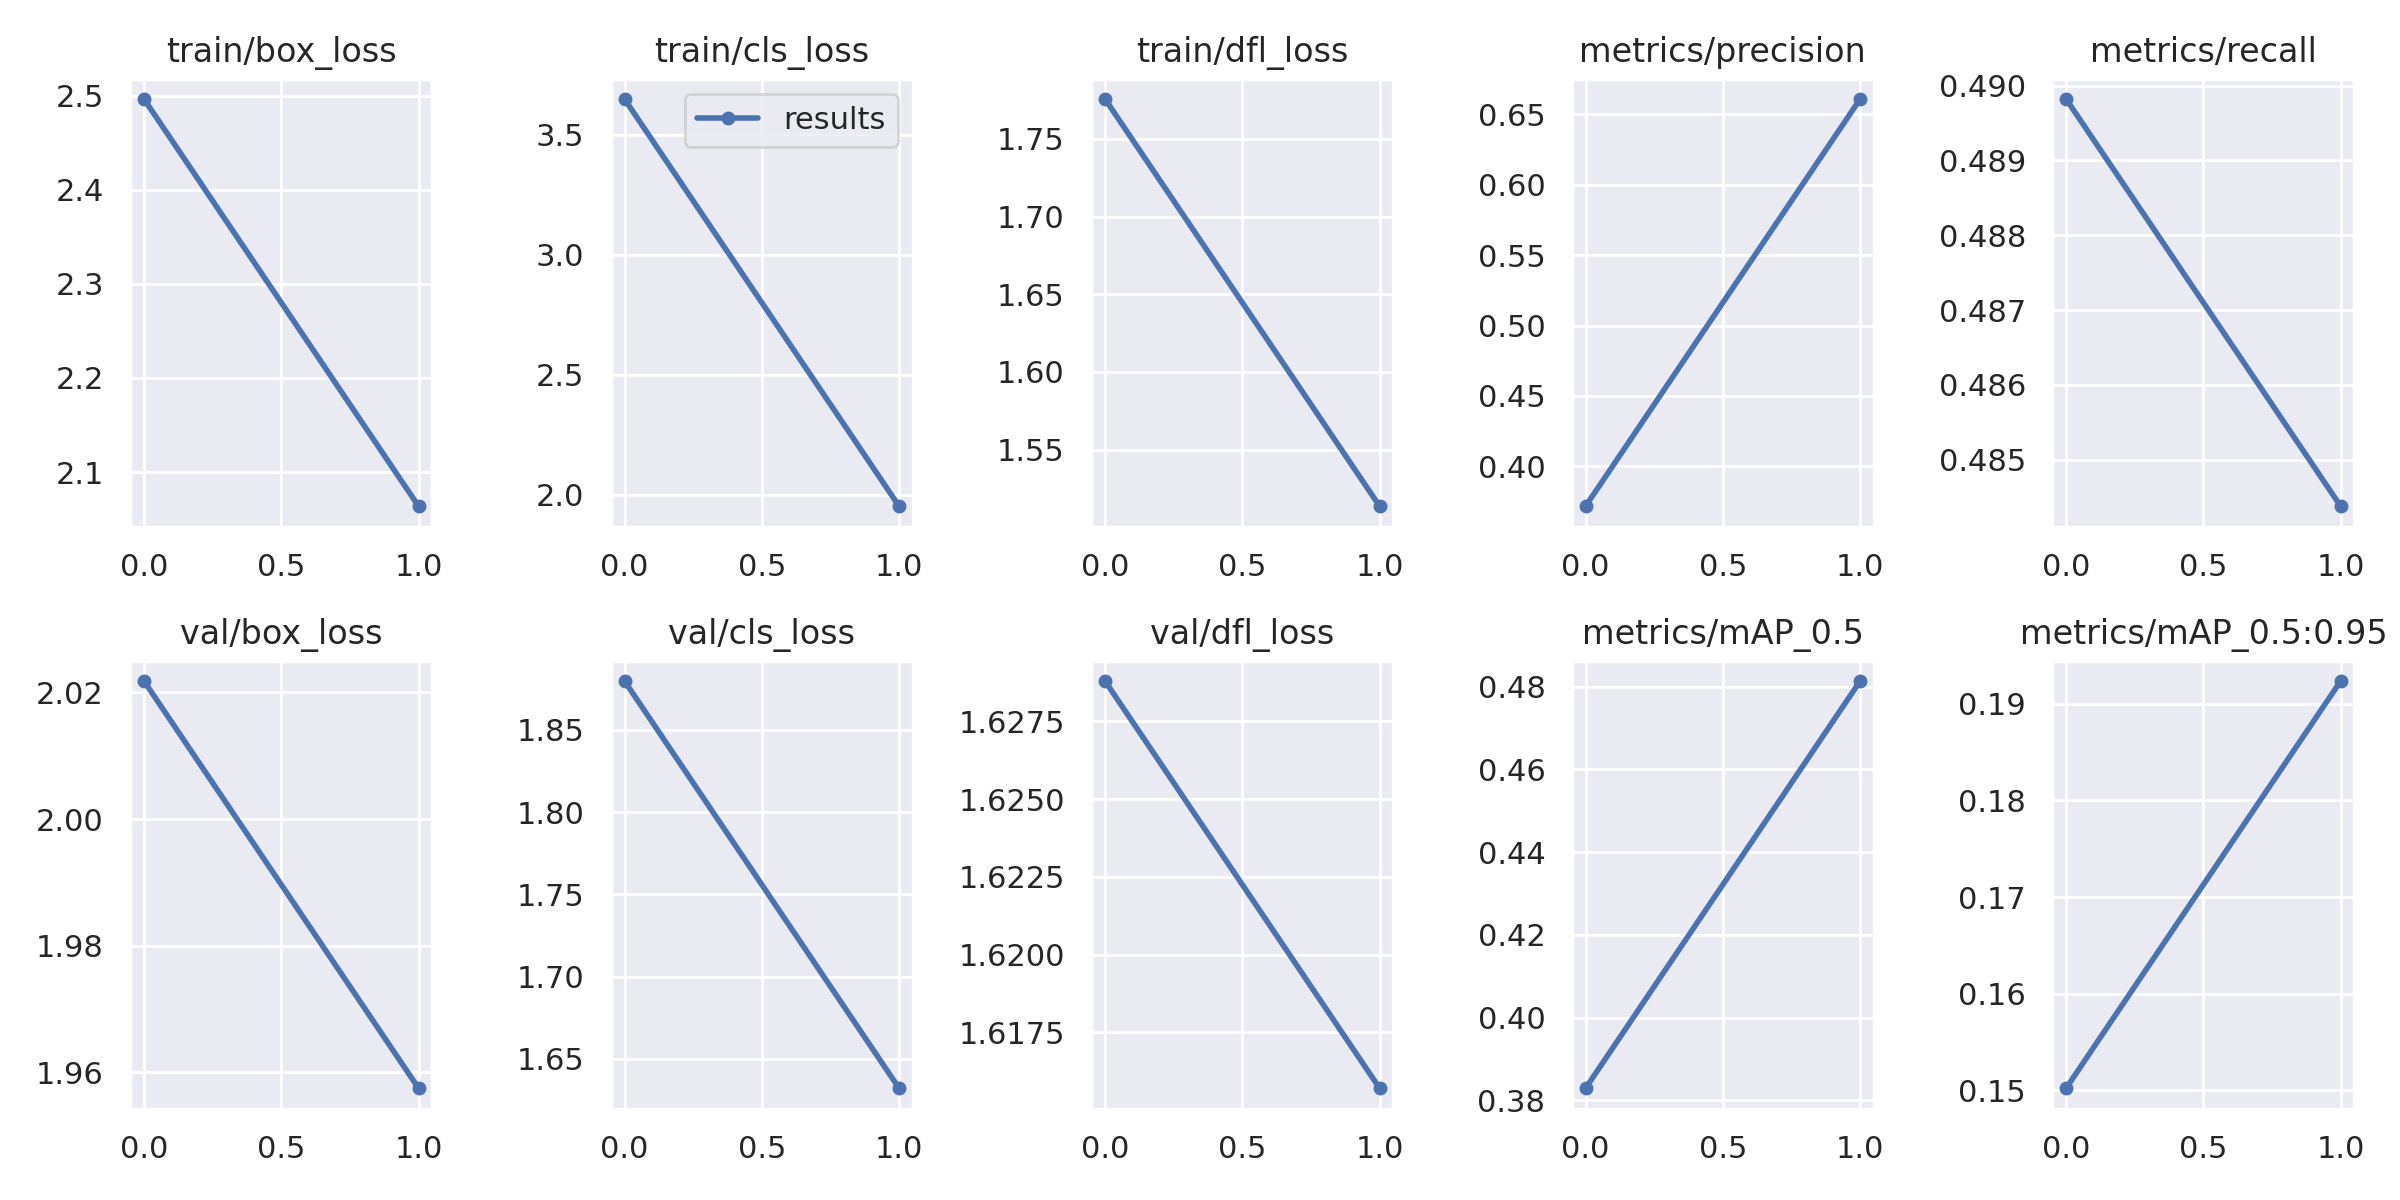

In [19]:
HISTORY_PATH = os.path.join(HOME, 'runs/train/exp/results.png')
training_history = Image.open(HISTORY_PATH)
training_history

In [20]:
FINETUNED_WEIGHTS_PATH = os.path.join(HOME, 'runs/train/exp/weights/best.pt')
TEST_DIR_PATH = os.path.join(HOME, 'data/test/images')

In [21]:
!python detect.py \
--img 1280 --conf 0.5 --device 0 \
--weights {FINETUNED_WEIGHTS_PATH} \
--source {TEST_DIR_PATH}

detect: weights=['/kaggle/working/yolov9/runs/train/exp/weights/best.pt'], source=/kaggle/working/yolov9/data/test/images, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)

/kaggle/working/yolov9/models/experimental.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In

In [22]:
%matplotlib inline

In [24]:
def show_random_results():
    img_path = glob.glob(f'{HOME}/runs/detect/exp/*.jpg')
    random_images = random.sample(img_path, 9) # get 9 img_path from path of images
    nrows, ncols = (3, 3)
    
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))
    
    for i, ax in enumerate(axes.flat):
        img = Image.open(random_images[i])
        ax.axis('off')
        ax.imshow(img)
        
    plt.show()

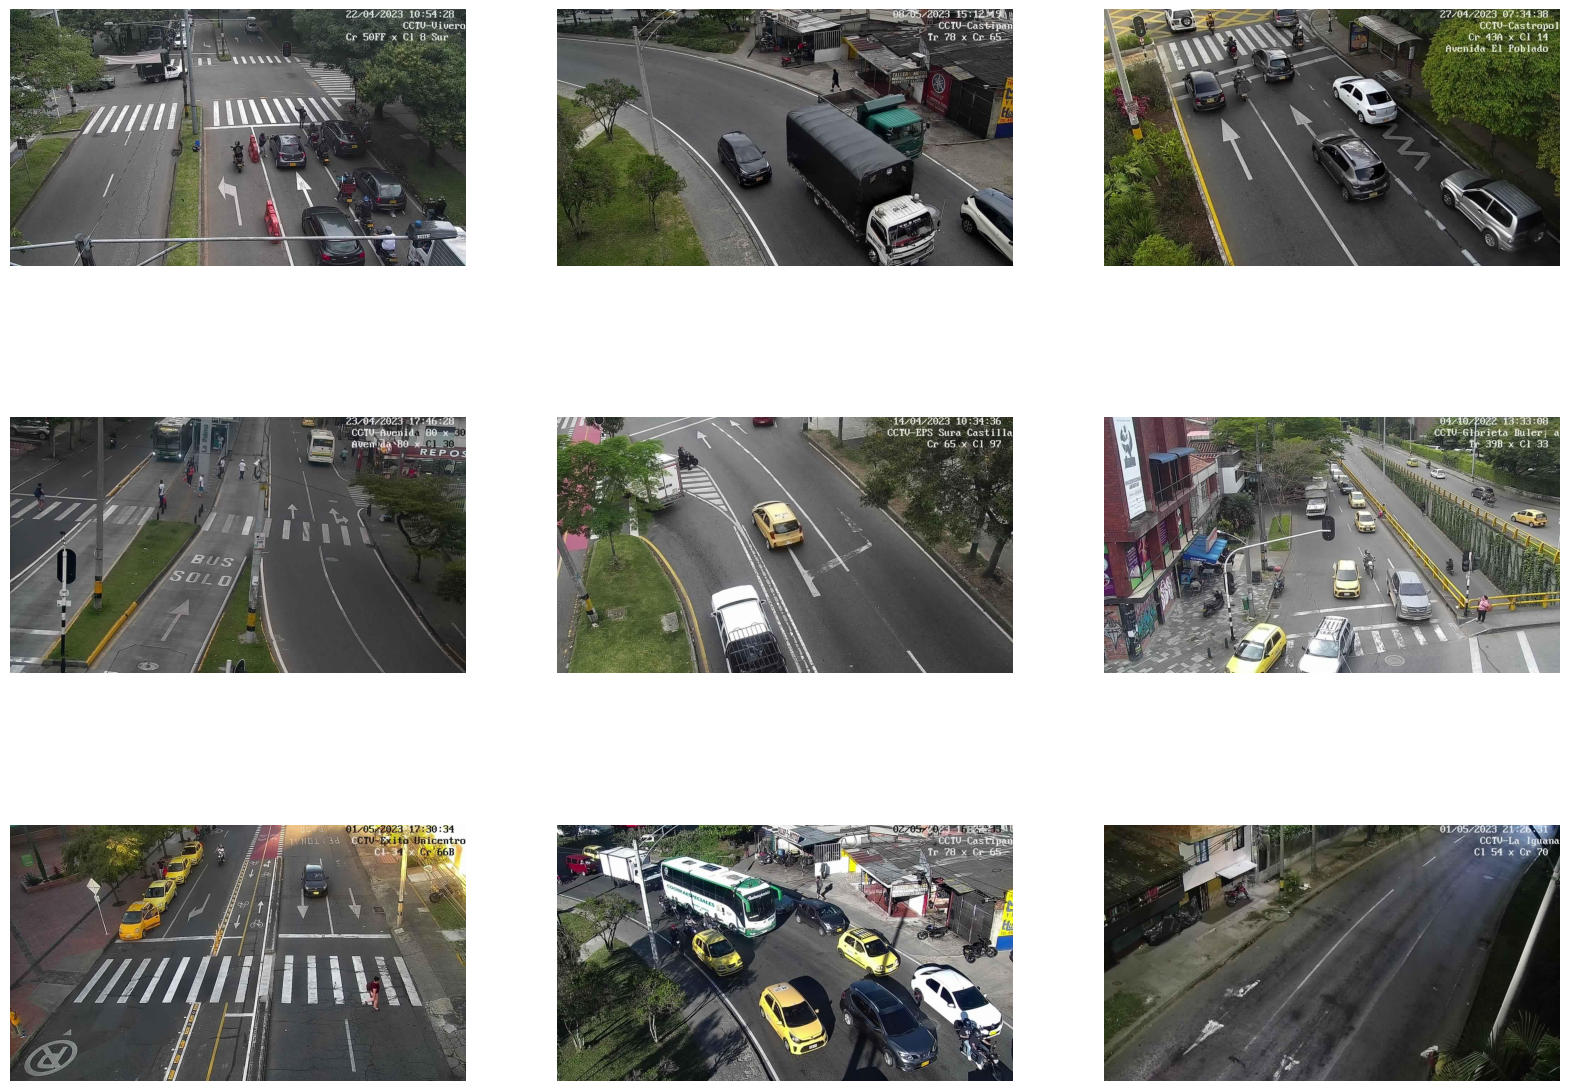

In [25]:
show_random_results()

In [26]:
from models.common import DetectMultiBackend
from utils.general import check_img_size, non_max_suppression, scale_boxes
from utils.torch_utils import select_device, smart_inference_mode
from utils.augmentations import letterbox

In [27]:
@smart_inference_mode()
def predict(
    image_path: str,
    weights: str,
    data: str,
    imgsz: tuple,
    conf_thres: float,
    iou_thres: float,
    device: str,
):
    device = select_device(device)
    model = DetectMultiBackend(weights, device=device, fp16=False, data=data)
    stride, names, pt = model.stride, model.names, model.pt

    # Load image
    image = Image.open(image_path)
    img0 = np.array(image)
    assert img0 is not None, f'Image Not Found {image_path}'
    img = letterbox(img0, imgsz, stride=stride, auto=True)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device).float()
    img /= 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    # Init bounding box annotator and label annotator
    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_position=sv.Position.TOP_RIGHT, text_scale=0.4)

    # Inference
    pred = model(img, augment=False, visualize=False)

    # Apply NMS
    pred_t = non_max_suppression(pred[0], conf_thres, iou_thres, classes=None, max_det=1000)

    # Process detections
    for i, det in enumerate(pred_t):
        if len(det):
            det[:, :4] = scale_boxes(img.shape[2:], det[:, :4], img0.shape).round()
            for *xyxy, conf, cls in reversed(det):
                # Transform detections to supervisions detections
                detections = sv.Detections(
                    xyxy=torch.stack(xyxy).cpu().numpy().reshape(1, -1),
                    class_id=np.array([int(cls)]),
                    confidence=np.array([float(conf)])
                )

                # Labels
                labels = [
                    f"{names[int(class_id)]} {confidence:0.2f}"
                    for class_id, confidence
                    in zip(detections.class_id, detections.confidence)
                ]

                img0 = bounding_box_annotator.annotate(img0, detections)
                img0 = label_annotator.annotate(img0, detections, labels)

        return img0

In [28]:
image_path = f'{HOME}/data/test/images/833.jpg'
image_path


'/kaggle/working/yolov9/data/test/images/833.jpg'

In [29]:
%matplotlib inline

In [30]:
FINETUNED_WEIGHTS_PATH = os.path.join('/kaggle/working/yolov9', 'weights/best.pt')
TEST_DIR_PATH = os.path.join('/kaggle/working/yolov9', 'test/images')

In [ ]:
img = predict(
    image_path=image_path,
    weights=FINETUNED_WEIGHTS_PATH,
    data=CUSTOM_DATA_YAML_PATH,
    imgsz=640,
    conf_thres=0.5,
    iou_thres=0.2,
    device=DEVICE,
)

sv.plot_image(img)